In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
import zipfile
zip_path = '/content/drive/MyDrive/Colab Notebooks/New York stock exchange data.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

!unzip '/content/drive/MyDrive/Colab Notebooks/New York stock exchange data.zip' -d '/content/stock exchange'

Archive:  /content/drive/MyDrive/Colab Notebooks/New York stock exchange data.zip
replace /content/stock exchange/fundamentals.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/stock exchange/prices-split-adjusted.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/stock exchange/prices.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/stock exchange/securities.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [48]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt

import math
from keras.models import Sequential
from keras.layers import Dense , BatchNormalization , Dropout , Activation
from keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam , SGD , RMSprop
print(os.listdir("../content/stock exchange"))

['prices-split-adjusted.csv', 'securities.csv', 'prices.csv', 'fundamentals.csv']


# **Analyzing the Data  **

In [49]:
df =  pd.read_csv('../content/prices.csv', header=0)
df.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [50]:
print(df.shape)

(851264, 7)


In [51]:
df.symbol.unique()[0:20]

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN'], dtype=object)

In [52]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


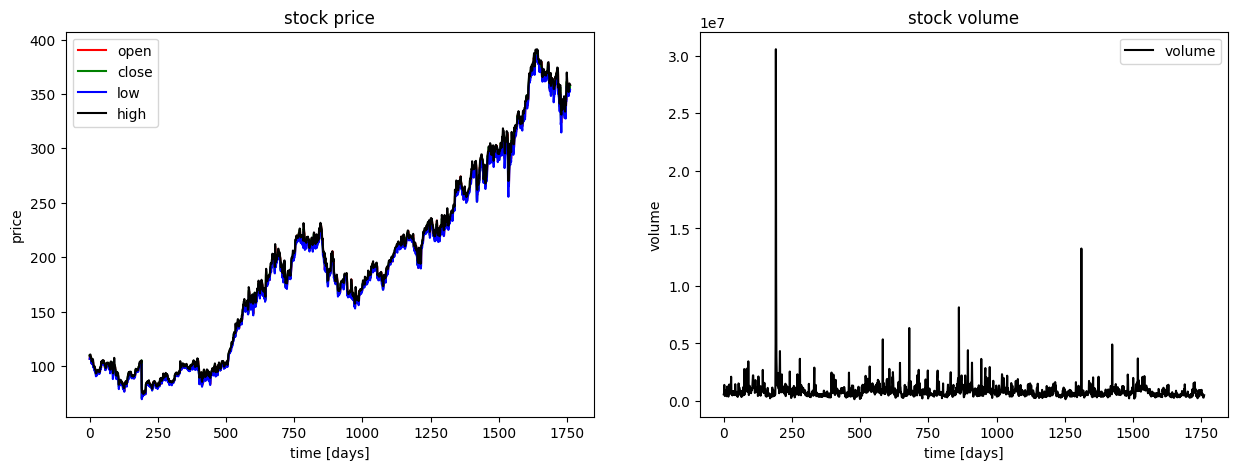

In [53]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [54]:
comp_info = pd.read_csv('../content/securities.csv')
comp_info.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


In [55]:
comp_plot = comp_info.loc[(comp_info["Security"] == 'Yahoo Inc.') | (comp_info["Security"] == 'Xerox Corp.') | (comp_info["Security"] == 'Adobe Systems Inc')
              | (comp_info["Security"] == 'Microsoft Corp.') | (comp_info["Security"] == 'Adobe Systems Inc')
              | (comp_info["Security"] == 'Facebook') | (comp_info["Security"] == 'Goldman Sachs Group') , ["Ticker symbol"] ]["Ticker symbol"]
print(comp_plot)

6      ADBE
181      FB
212      GS
306    MSFT
496     XRX
500    YHOO
Name: Ticker symbol, dtype: object


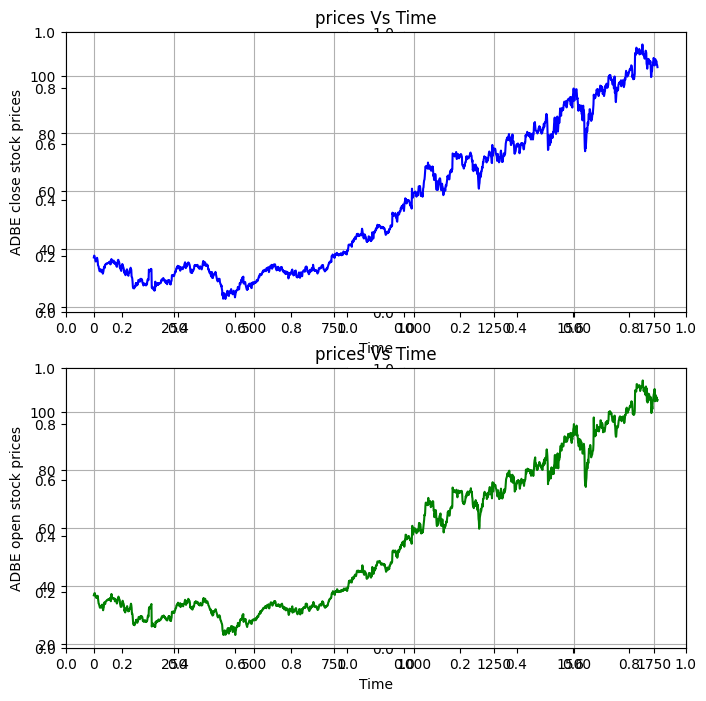

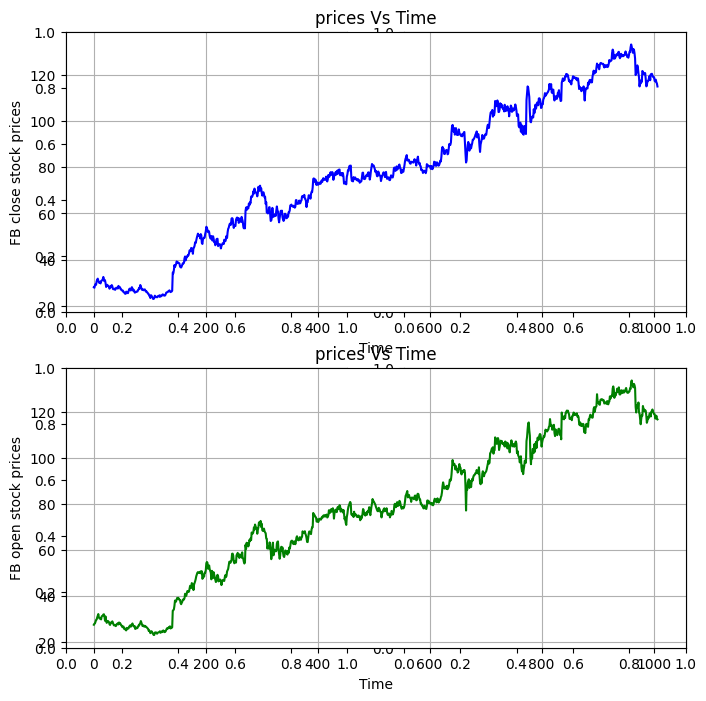

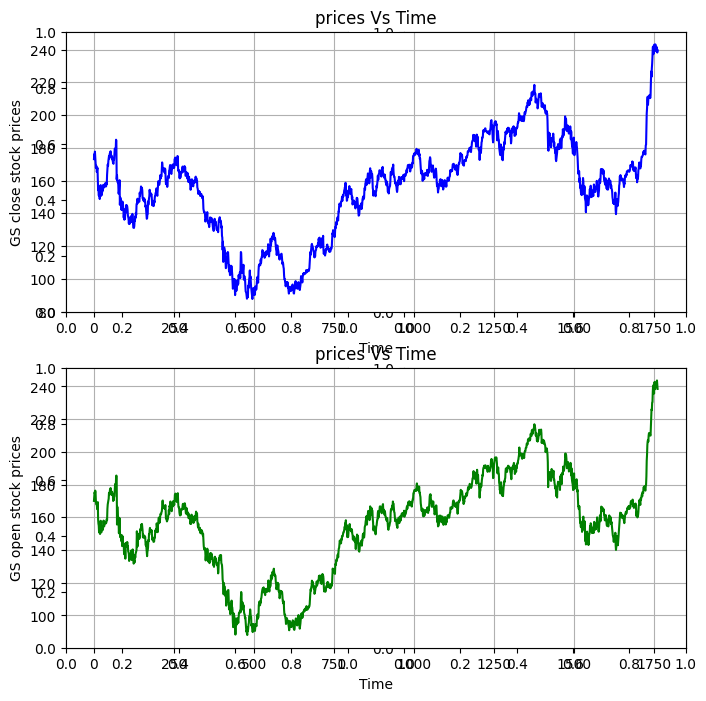

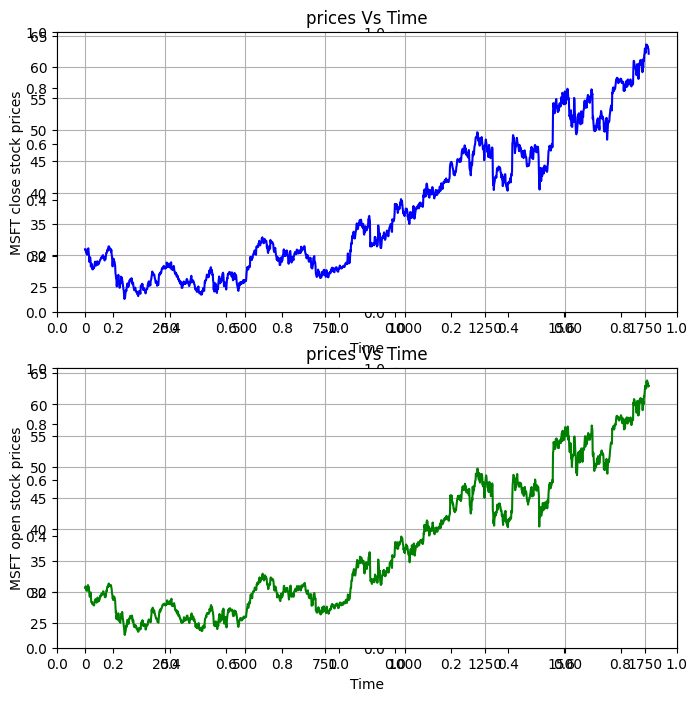

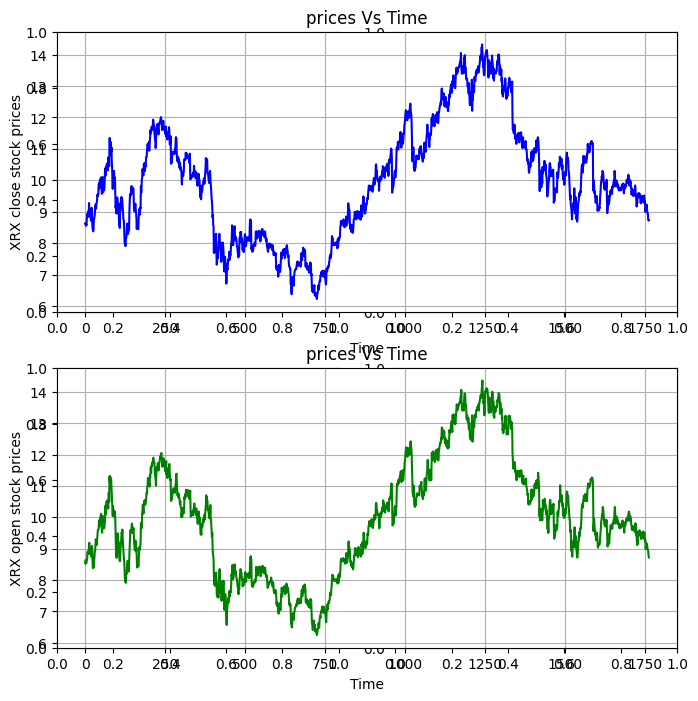

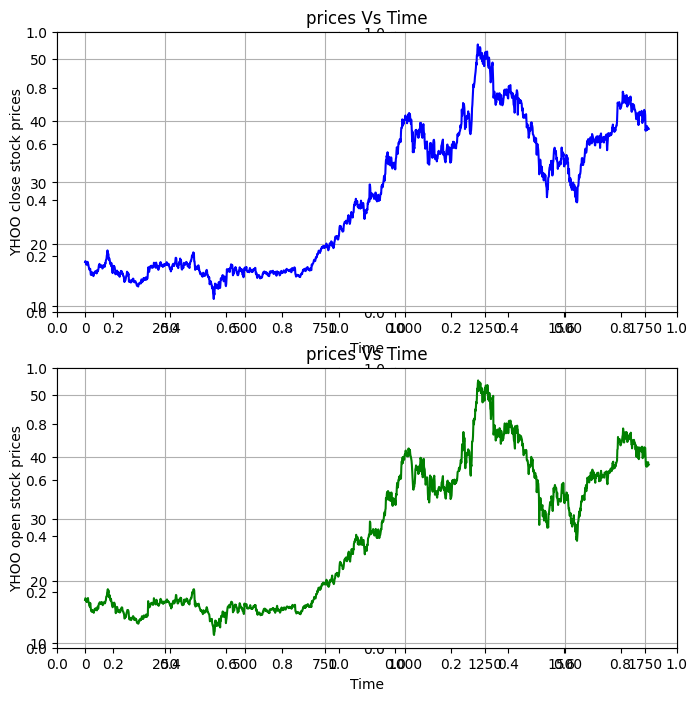

In [56]:
def plotter(code):
    global closing_stock
    global opening_stock
    f, axs = plt.subplots(2,2,figsize=(8,8))
    plt.subplot(212)
    company = df[df['symbol']==code]
    company = company.open.values.astype('float32')
    company = company.reshape(-1, 1)
    opening_stock = company
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel(code + " open stock prices")
    plt.title('prices Vs Time')
    plt.plot(company , 'g')

    plt.subplot(211)
    company_close = df[df['symbol']==code]
    company_close = company_close.close.values.astype('float32')
    company_close = company_close.reshape(-1, 1)
    closing_stock = company_close
    plt.xlabel('Time')
    plt.ylabel(code + " close stock prices")
    plt.title('prices Vs Time')
    plt.grid(True)
    plt.plot(company_close , 'b')
    plt.show()
for i in comp_plot:
    plotter(i)

##**Manipulating the Data**

Choosing one stock to predict

In [57]:
closing_stock[: , 0]

array([17.1 , 17.23, 17.17, ..., 38.73, 38.64, 38.67], dtype=float32)

In [58]:
stocks = closing_stock[: , 0]
print(stocks)
stocks = stocks.reshape(len(stocks) , 1)

[17.1  17.23 17.17 ... 38.73 38.64 38.67]


In [59]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
stocks = scaler.fit_transform(stocks)

In [60]:
train = int(len(stocks) * 0.80)
test = len(stocks) - train

In [61]:
print(train , test)

1409 353


In [62]:
train = stocks[0:train]
print(train)

[[0.14559111]
 [0.14874032]
 [0.14728683]
 ...
 [0.63372093]
 [0.6145833 ]
 [0.6196705 ]]


In [63]:
test = stocks[len(train) : ]

In [64]:
train = train.reshape(len(train) , 1)
test = test.reshape(len(test) , 1)
print(train.shape , test.shape)

(1409, 1) (353, 1)


In [65]:
def process_data(data , n_features):
    dataX, dataY = [], []
    for i in range(len(data)-n_features-1):
        a = data[i:(i+n_features), 0]
        dataX.append(a)
        dataY.append(data[i + n_features, 0])
    return np.array(dataX), np.array(dataY)

In [66]:
n_features = 2

trainX, trainY = process_data(train, n_features)
testX, testY = process_data(test, n_features)

In [67]:
print(trainX.shape , trainY.shape , testX.shape , testY.shape)

(1406, 2) (1406,) (350, 2) (350,)


In [68]:
trainX = trainX.reshape(trainX.shape[0] , 1 ,trainX.shape[1])
testX = testX.reshape(testX.shape[0] , 1 ,testX.shape[1])

## **process_data for the required input for LSTM**

In [69]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Activation
from tensorflow.keras.layers import LSTM , GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras import activations

In [70]:
filepath="stock_weights.keras"
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max')

In [71]:
model = Sequential()
# Directly use activation functions like 'tanh', 'relu', 'linear'
model.add(GRU(256 , input_shape = (1 , n_features) , return_sequences=True, activation='tanh'))
model.add(Dropout(0.4))
model.add(LSTM(256, activation='tanh'))
model.add(Dropout(0.4))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1, activation='linear'))
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 1, 256)              │         199,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 741,505 (2.83 MB)

 Trainable params: 741,505 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

None


In [72]:
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005) , metrics = ['mean_squared_error'])

In [73]:
history = model.fit(trainX, trainY, epochs=100 , batch_size = 64 ,
          callbacks = [checkpoint , lr_reduce] , validation_data = (testX,testY))

Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1472 - mean_squared_error: 0.1472
Epoch 1: val_loss improved from -inf to 0.00140, saving model to stock_weights.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - val_loss: 0.0014 - val_mean_squared_error: 0.0014 - learning_rate: 5.0000e-04
Epoch 2/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 2: val_loss improved from 0.00140 to 0.00822, saving model to stock_weights.keras

Epoch 2: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - learning_rate: 5.0000e-04
Epoch 3/100
19/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - mean_squared_error: 0.0062 
Epoch 3: val_loss did not improve from 0.00822

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.000000237487257e-06.
22/22 ━━━━━

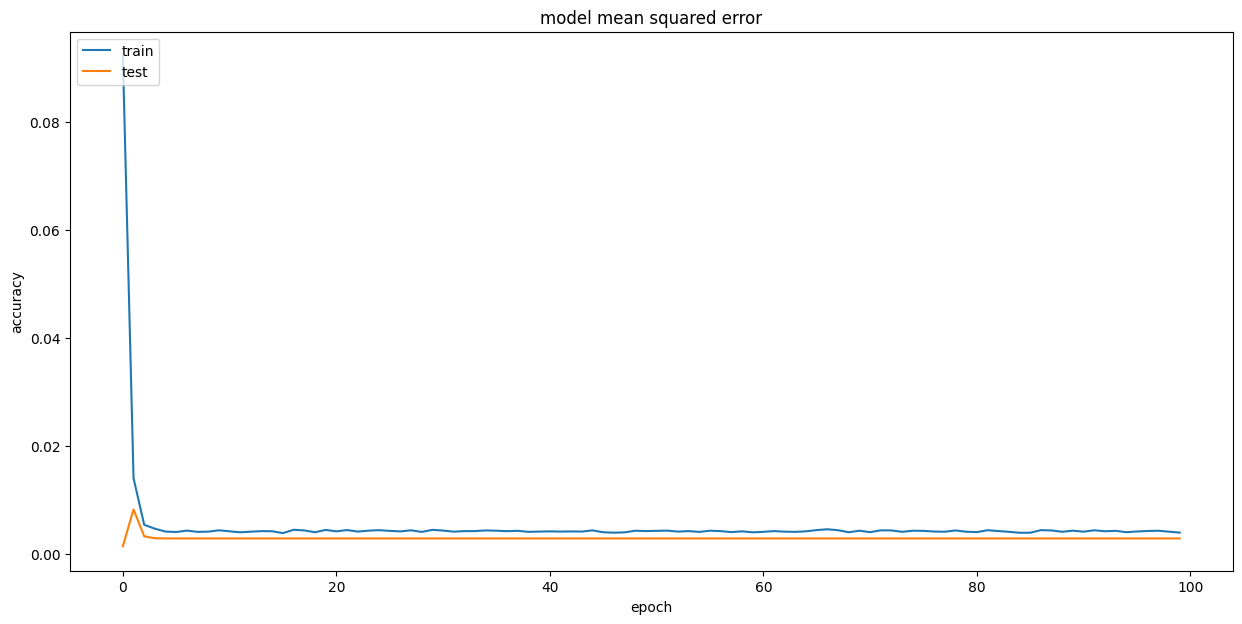

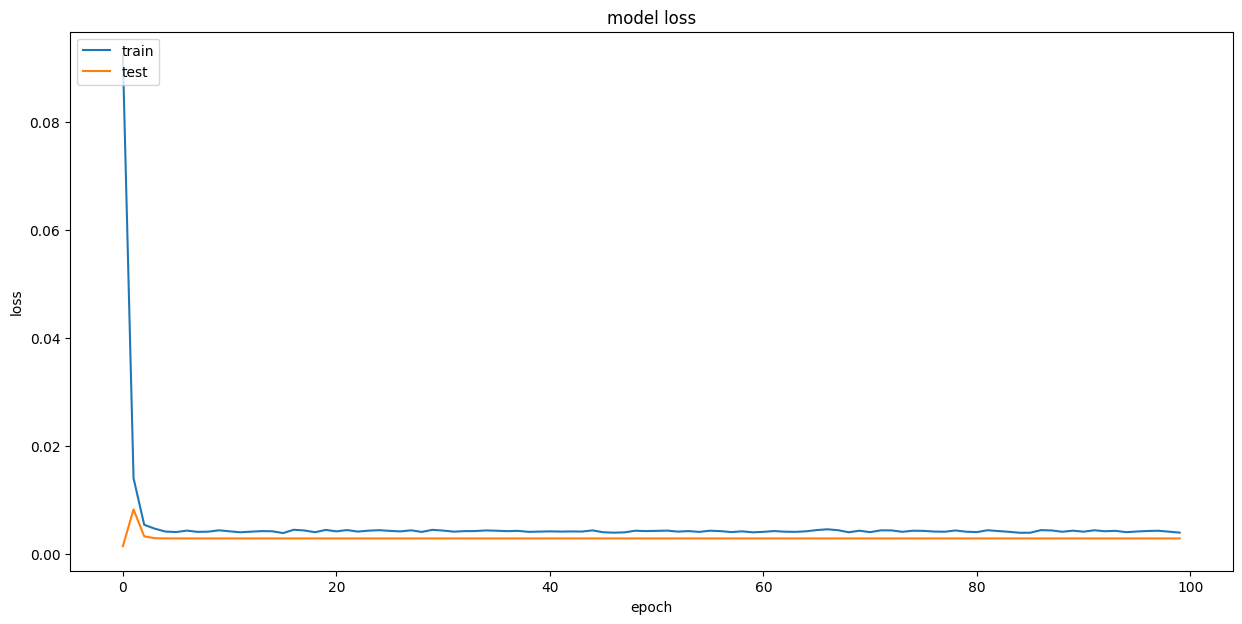

In [74]:
import matplotlib.pyplot as plt

plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean squared error')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [75]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, trainX, trainY , testX, testY)

Train Score: 0.00300 MSE (0.05 RMSE)
Test Score: 0.00285 MSE (0.05 RMSE)


(0.0029971792828291655, 0.002847325522452593)

# **Predicting the Data**

In [76]:
pred = model.predict(testX)
pred = scaler.inverse_transform(pred)
pred[:10]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


array([[34.57186 ],
       [33.468304],
       [33.389095],
       [34.132145],
       [34.208744],
       [33.98278 ],
       [33.604916],
       [32.951664],
       [32.016872],
       [30.872746]], dtype=float32)

In [77]:
testY = testY.reshape(testY.shape[0] , 1)
testY = scaler.inverse_transform(testY)
testY[:10]

array([[34.49    ],
       [35.93    ],
       [36.24    ],
       [36.1     ],
       [35.69    ],
       [35.19    ],
       [34.1     ],
       [32.93    ],
       [31.31    ],
       [31.739998]], dtype=float32)

Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices


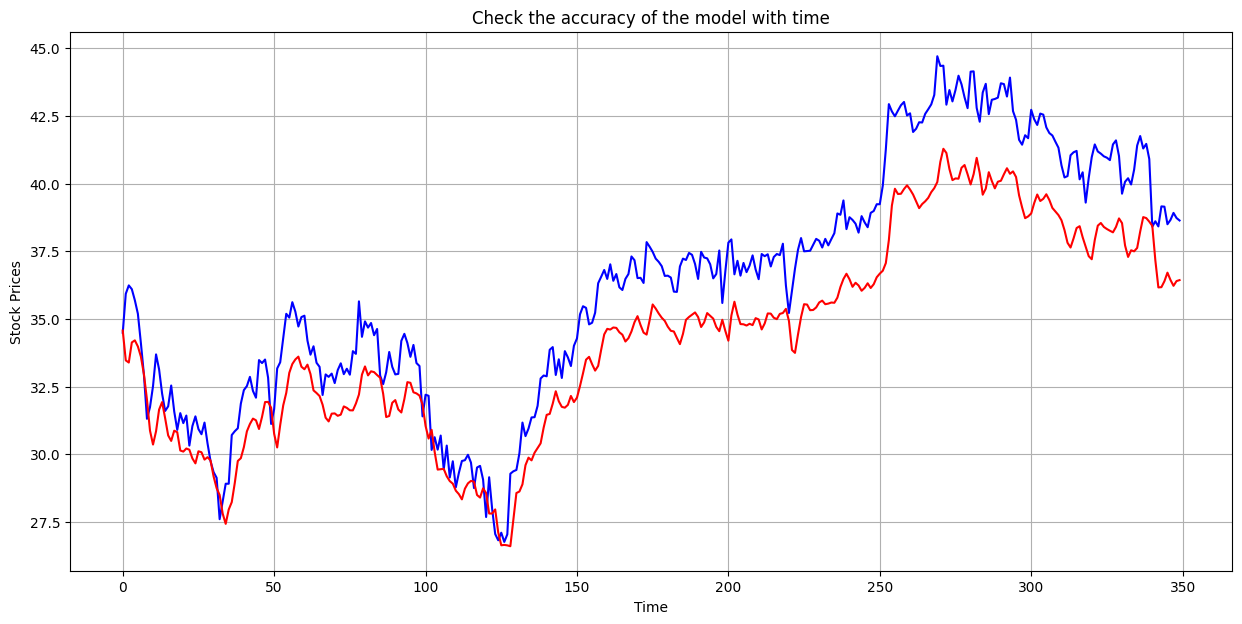

In [78]:
print("Red - Predicted Stock Prices  ,  Blue - Actual Stock Prices")
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(testY , 'b')
plt.plot(pred , 'r')
plt.xlabel('Time')
plt.ylabel('Stock Prices')
plt.title('Check the accuracy of the model with time')
plt.grid(True)
plt.show()

To improve the loss from 0.005 to 0.0039, I lowered the batch size from 128 to 64. Thus allowing the model's weights to update more frequently since gradients are computed after processing fewer samples.